# Exploring Lung Cancer

**🫁 Lung Cancer Risk Prediction Based on Environmental Factors**


---


📘 Overview

Lung cancer remains the leading cause of cancer-related deaths globally, claiming over **1.80 million lives** in 2020 alone. While smoking is a well-established cause, non-smokers are not exempt. Increasing evidence suggests that air pollution—especially prolonged exposure to fine particulate matter (PM2.5)—may significantly elevate the risk of lung cancer, even in individuals who have never smoked.

**🧠 Objective**

---



The *aim* of this notebook is to:
Model lung cancer risk using *supervised machine learning* techniques
Apply* explainable AI (XAI) *tools (like SHAP or LIME) to understand what features most influence model predictions

## Dependencies and Data Loading

In [1]:
# ! pip install numpy pandas matplotlib seaborn scikit-learn shap lime --quiet
# ! pip install xgboost lightgbm catboost --quiet
# ! pip install rich --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from rich import print
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4) # does not use letter e for printing

print(f"NumPy version       : {np.__version__}")
print(f"Pandas version      : {pd.__version__}")
print(f"Matplotlib version  : {matplotlib.__version__}")
print(f"Seaborn version     : {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


NumPy version       : 2.2.5

Pandas version      : 2.2.3

Matplotlib version  : 3.10.3

Seaborn version     : 0.13.2

Scikit-learn version: 1.6.1

In [3]:
df=pd.read_csv("./cancer patient data sets.csv")
df=df.drop(labels=["index","Patient Id"],axis=1)
df.head(5)

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


In [4]:
print("Shape:",df.shape)
print("Columns:",df.columns)
print("Total Null values in dataset:",df.isnull().sum().sum())

Shape:
(1000, 24)

Columns: Index(['Age', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy',
       'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease',
       'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain',
       'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath',
       'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails',
       'Frequent Cold', 'Dry Cough', 'Snoring', 'Level'],
      dtype='object')

Total Null values in dataset: 0

Observation :
* Contribution of ['Alcohol use', 'Fatigue', 'Passive Smoker', 'Genetic Risk', 'Obesity','OccuPational Hazards', 'Dust Allergy', 'Age'] is high

In [5]:
type(df["Fatigue"].value_counts())

pandas.core.series.Series

## Train-Test Split and Feature Description

In [6]:
features_description = {
    
    "Age": "Numeric - Age of the patient",
    "Gender": "Categorical - Gender of the patient",
    "Air Pollution": "Categorical - Level of air pollution exposure",
    "Alcohol use": "Categorical - Level of alcohol use",
    "Dust Allergy": "Categorical - Level of dust allergy",
    "OccuPational Hazards": "Categorical - Level of occupational hazards",
    "Genetic Risk": "Categorical - Level of genetic risk",
    "chronic Lung Disease": "Categorical - Level of chronic lung disease",
    "Balanced Diet": "Categorical - Level of balanced diet",
    "Obesity": "Categorical - Level of obesity",
    "Smoking": "Categorical - Level of smoking",
    "Passive Smoker": "Categorical - Level of passive smoking exposure",
    "Chest Pain": "Categorical - Level of chest pain",
    "Coughing of Blood": "Categorical - Level of coughing of blood",
    "Fatigue": "Categorical - Level of fatigue",
    "Weight Loss": "Categorical - Level of weight loss",
    "Shortness of Breath": "Categorical - Level of shortness of breath",
    "Wheezing": "Categorical - Level of wheezing",
    "Swallowing Difficulty": "Categorical - Level of swallowing difficulty",
    "Clubbing of Finger Nails": "Categorical - Level of clubbing of finger nails",
    'Frequent Cold':"Categorical - Frequency of COld",
    'Dry Cough':"Categorical -Level of Cough",
    'Snoring':"Categorical - Level of Snoring",
    'Level':"Categorical - Low,Medium,High "
}

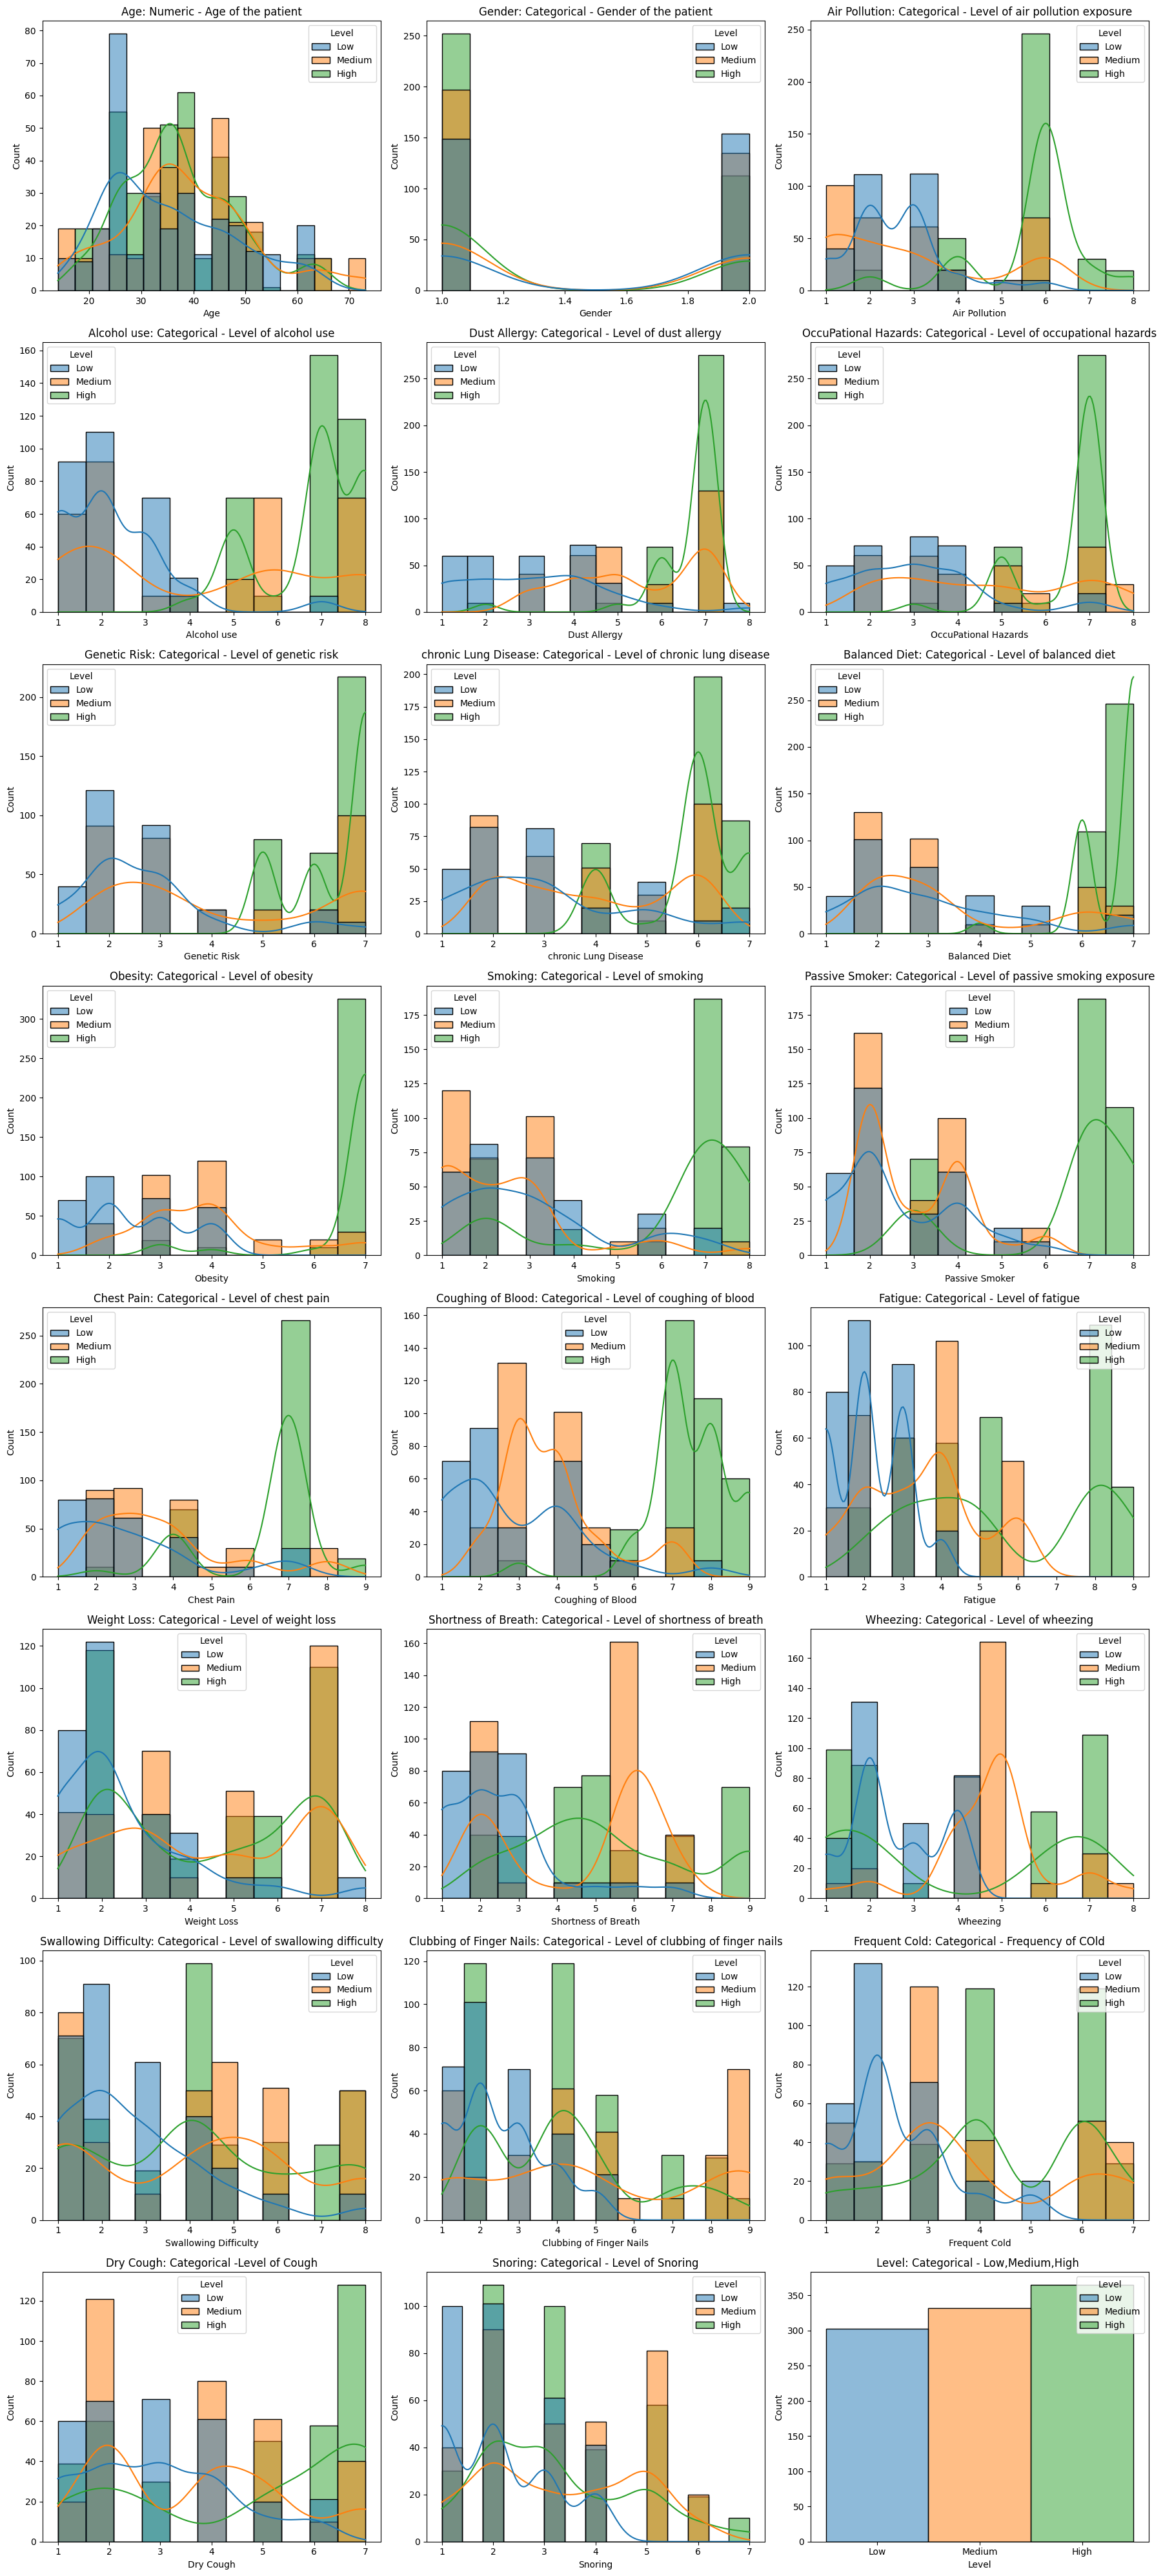

In [8]:
import math
features = df.columns
n_cols = 3
n_rows = math.ceil(len(features) / n_cols)
plt.figure(figsize=(18, 5 * n_rows))

for i, column in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=column, kde=True, hue="Level")
    plt.title(f"{column}: {features_description[column]}")
    plt.tight_layout()

plt.show()

In [9]:
X,y=df.iloc[:,:-1],df.iloc[:,-1]
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=1)

## Filter Methods

🔍 Filter Methods:
- Select features independently of any machine learning model.
- Based on statistical scores like correlation, chi-square, mutual information.
- ❌ Doesn’t consider how features interact with a specific model
- Reference: https://www.ibm.com/think/topics/feature-selection

### 1.Variance

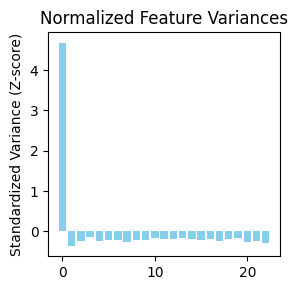

In [14]:
variances = df.iloc[:,:-1].var()
scaler = sklearn.preprocessing.StandardScaler()
normalized_variance = scaler.fit_transform(variances.values.reshape(-1, 1)).flatten()
plt.figure(figsize=(3,3))
plt.bar(list(range(len(df.iloc[:,:-1].columns))), normalized_variance, color='skyblue')
plt.title("Normalized Feature Variances")
plt.ylabel("Standardized Variance (Z-score)")
plt.tight_layout()
plt.show()

Observation:Cannot exclude any column since all have low variances

### 2. K Best Features (using Information Gain)

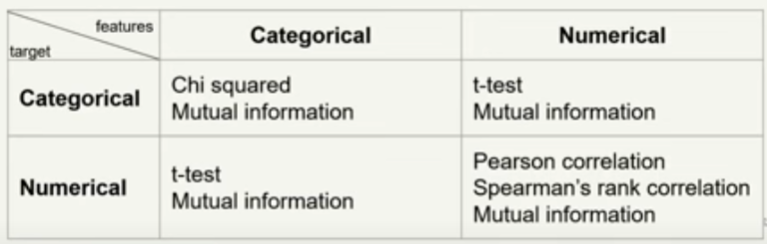

In [15]:
gbc = sklearn.ensemble.GradientBoostingClassifier(max_depth=5, random_state=42)
f1_score_list = []
for k in range(1,df.shape[1]-1):
    selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.mutual_info_classif, k=k)
    selector.fit(X_train, y_train)
    sel_X_train = selector.transform(X_train)
    sel_X_test = selector.transform(X_test)
    gbc.fit(sel_X_train, y_train)
    y_pred = gbc.predict(sel_X_test)
    f1_score_kbest = round(sklearn.metrics.f1_score(y_test, y_pred, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)

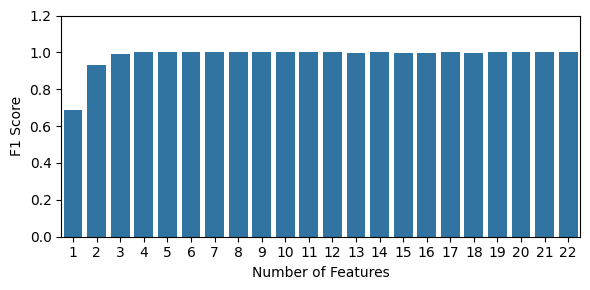

In [16]:
plt.figure(figsize=(6, 3))
sns.barplot(x=np.arange(1, len(f1_score_list)+1), y=f1_score_list)
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()

### 📘 Mutual Information using Entropy


Mutual Information between two random variables X and Y is defined as:

$$
I(X; Y) = H(X) - H(X \mid Y)
$$

Or equivalently:

$$
I(X; Y) = H(Y) - H(Y \mid X)
$$

Or in terms of joint entropy:

$$
I(X; Y) = H(X) + H(Y) - H(X, Y)
$$

Where H(W) is entropy of W

- If X and Y are independent, then \( I(X; Y) = 0 \).


Observation:
* Using LR couldn't converge to best soln. even using 500 epochs
* Using gbc getting good f1-score using 4 features

In [17]:
selector = sklearn.feature_selection.SelectKBest(
    sklearn.feature_selection.mutual_info_classif, k=3)
selector.fit(X_train, y_train)
selected_feature_mask = selector.get_support()
selected_feature_mask # returns boolean array

array([False, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False])

In [18]:
top_3_columns=[]
for index,column in enumerate(df.columns[:-1]):
  if(selected_feature_mask[index]):
    top_3_columns.append(column)
top_3_columns

['Alcohol use', 'Passive Smoker', 'Coughing of Blood']

### 3. Chi Square Test (used for Categorical Data)


- Compute chi-squared stats between each non-negative feature and class.
- must contain only non-negative integer feature values such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.
- If some of your features are continuous, you need to bin them, for example by using KBinsDiscretizer.

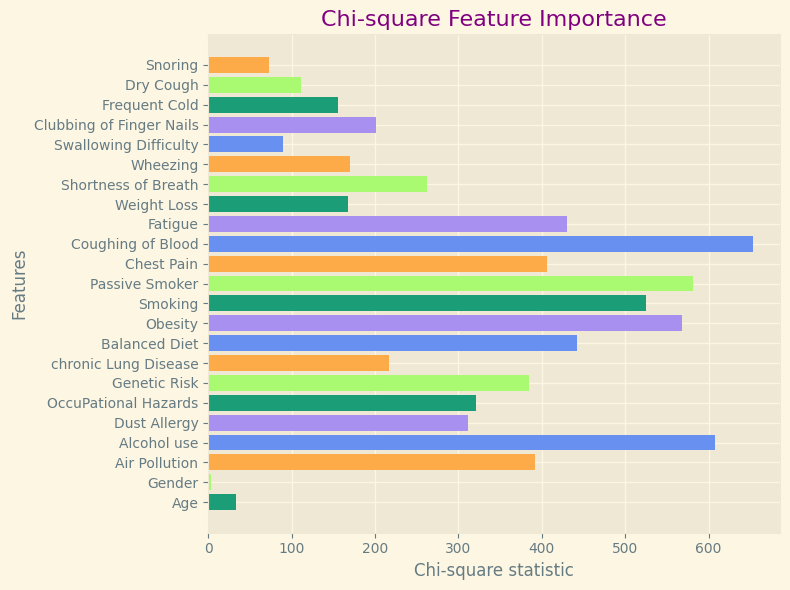

In [19]:
chi2_stats, p_values = sklearn.feature_selection.chi2(X_train, y_train)
# Make sure your color list matches or exceeds the number of features
color_list = ['#1b9e77', '#a9f971', '#fdaa48', '#6890F0', '#A890F0']
plt.style.use('Solarize_Light2')  # Correct usage
# Plotting chi-square values against feature names
plt.figure(figsize=(8, 6))
plt.barh(y=df.columns[:-1], width=chi2_stats, color=color_list[:len(df.columns[:-1])])
plt.title("Chi-square Feature Importance", color="purple")
plt.xlabel("Chi-square statistic")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Observation:
- Coughing of Blood ,Alcohol Use,Passive smoker,Obesity,Smoking is decreasing order of chi square values

## Wrapper Methods

🧪 Wrapper Methods:
- Use the model itself to evaluate feature subsets.
- Try different combinations → train → test → pick the best set.
- ❌ Slower, computationally expensive

# Model Training

## Model Imports

In [20]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [21]:
observed_columns=[3,11,13,9,10]
print(df.columns[observed_columns])

Index(['Alcohol use', 'Passive Smoker', 'Coughing of Blood', 'Obesity',
       'Smoking'],
      dtype='object')

## Desicion Tree Classifier

precision    recall  f1-score   support

        High       1.00      1.00      1.00        76
         Low       1.00      1.00      1.00        62
      Medium       1.00      1.00      1.00        62

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

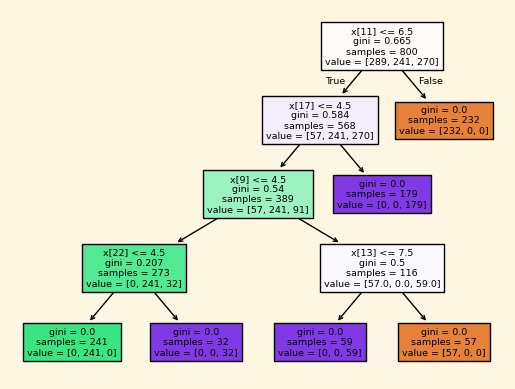

In [22]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
y_pred_dt=dt.predict(X_test)
print(classification_report(y_test,y_pred_dt))
_=plot_tree(dt,filled=True)

Observation:
- DT is using only columns Passive Smoker,Wheezing,Obesity,Coughing of Blood,Snoring and giving 100% accuracy

## Gaussian Naive Bayes

In [23]:
# 8. Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(classification_report(y_test,y_pred_nb))

precision    recall  f1-score   support

        High       0.91      0.99      0.95        76
         Low       1.00      0.92      0.96        62
      Medium       0.90      0.89      0.89        62

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200

## Logistic Regression

In [24]:
#inorder to make shap visualization easier,,,
#shap doesnt take categorical values as input
levels={
    "High":0,
    "Medium":1,
    "Low":2
}
y_train=y_train.apply(lambda x:levels[x])
y_test=y_test.apply(lambda x:levels[x])

In [25]:
lr=LogisticRegression(max_iter=100)
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
lr_accuracy_score=accuracy_score(y_test,y_pred_lr)
print(classification_report(y_test,y_pred_lr))
print(confusion_matrix(y_test,y_pred_lr))

precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      0.95      0.98        62
           2       0.95      1.00      0.98        62

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

[[76  0  0]
 [ 0 59  3]
 [ 0  0 62]]

## Logisitc Regression with observed columns

In [26]:
X_train_obs=X_train.iloc[:,observed_columns]
X_test_obs=X_test.iloc[:,observed_columns]
lr_obs=LogisticRegression(max_iter=100)
lr_obs.fit(X_train_obs,y_train)
y_pred_lr_obs=lr_obs.predict(X_test_obs)
lr_accuracy_score=accuracy_score(y_test,y_pred_lr_obs)
print(classification_report(y_test,y_pred_lr_obs))
print(confusion_matrix(y_test,y_pred_lr_obs))

precision    recall  f1-score   support

           0       0.93      0.99      0.96        76
           1       0.67      0.56      0.61        62
           2       0.69      0.74      0.71        62

    accuracy                           0.78       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.77      0.78      0.77       200

[[75  1  0]
 [ 6 35 21]
 [ 0 16 46]]

## Random Forest

In [27]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(classification_report(y_test,y_pred))

precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        62

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

# Model Explanation


## SHAP
**Shapely Additive Values**

- Reference : 
* https://youtu.be/dZANiP_cOB0?si=JcJi6pzpgCQO_swE (best to understand)
* https://youtu.be/NBg7YirBTN8?si=0O0ZNXsFKRKvKG92 #very nice
* https://youtube.com/playlist?list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK&si=JtEsMGb6BGdccR3w

In [28]:
import shap
shap.initjs()
X100=X_test.iloc[:100,:].to_numpy()
print(X100.dtype)

int64

In [29]:
# print(X_test.iloc[1].shape)
# print(X_test.iloc[1])	# Returns a Series → shape (n_features,)
# print(X_test.iloc[[1]].shape)
# X_test.iloc[[1]]	# Returns a DataFrame → shape (1, n_features)


In [103]:
print(lr.predict(X_test.iloc[[1]]))
print(lr.predict_proba(X_test.iloc[[1]]))

[2]

[[0.     0.0739 0.9261]]

In [30]:
explainer = shap.Explainer(lr.predict, X100, feature_names = X_train.columns.to_list(), output_names = list(levels.keys()) )
shap_values = explainer(X100) #better to give smaller dataset,but X is already small-1000
print("Shape of shap_values",shap_values.shape) #23 shap values for each row

PermutationExplainer explainer: 101it [00:11,  8.67it/s]                         


Shape of shap_values
(100, 23)

In [31]:
# shap_values

In [32]:
ROW=1

In [33]:
lr.predict(X100[[ROW]])

array([2])

In [34]:
#understanding the shap_values explanation object\
from rich.console import Console
from rich.table import Table
table = Table(title="My Data Table")
table.add_column("Column Name", style="cyan", no_wrap=True)
table.add_column("Value", style="magenta", justify="center")
table.add_column("Shap value", style="green", justify="right")
for idx,column in enumerate(X.columns):
    table.add_row(str(column),str(shap_values[ROW].data[idx]),str(shap_values[ROW].values[idx]))
console = Console()
console.print(table)
    

                        My Data Table                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Column Name              ┃ Value ┃             Shap value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Age                      │  26   │                -0.1025 │
│ Gender                   │   1   │   -0.05650000000000001 │
│ Air Pollution            │   2   │                 0.0745 │
│ Alcohol use              │   3   │    0.20850000000000005 │
│ Dust Allergy             │   1   │   -0.30999999999999994 │
│ OccuPational Hazards     │   4   │   0.002499999999999969 │
│ Genetic Risk             │   3   │    0.14249999999999996 │
│ chronic Lung Disease     │   2   │ -0.0060000000000000105 │
│ Balanced Diet            │   3   │    0.01549999999999998 │
│ Obesity                  │   4   │ -0.0035000000000000252 │
│ Smoking                  │   3   │   -0.04300000000000001 │
│ Passive Smoker           │   1   │                  0.384 │
│ Chest Pain               │   4   │  -0.027499999999999997 │
│ Coughing of Blood        │   3   │    0.06600000000000002 │
│ Fatigue                  │   1   │                 0.5545 │
│ Weight Loss              │   2   │   -0.05199999999999998 │
│ Shortness of Breath      │   3   │   0.009499999999999991 │
│ Wheezing                 │   4   │   0.025000000000000012 │
│ Swallowing Difficulty    │   5   │   -0.04199999999999999 │
│ Clubbing of Finger Nails │   1   │    0.03949999999999999 │
│ Frequent Cold            │   2   │  -0.010499999999999999 │
│ Dry Cough                │   3   │   0.023000000000000013 │
│ Snoring                  │   4   │   0.048499999999999995 │
└──────────────────────────┴───────┴────────────────────────┘

In [35]:
# shap_values[1]

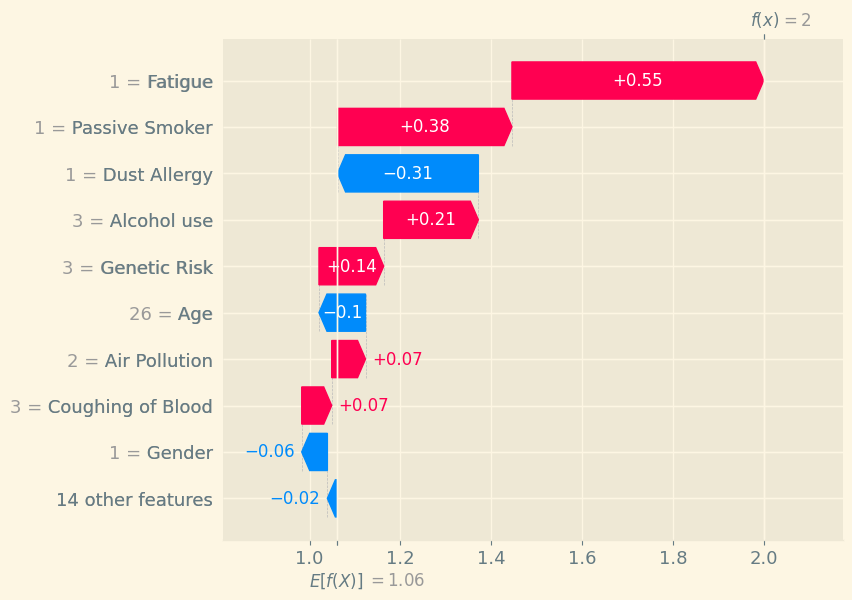

In [36]:
shap.plots.waterfall(shap_values[1],show=True) 

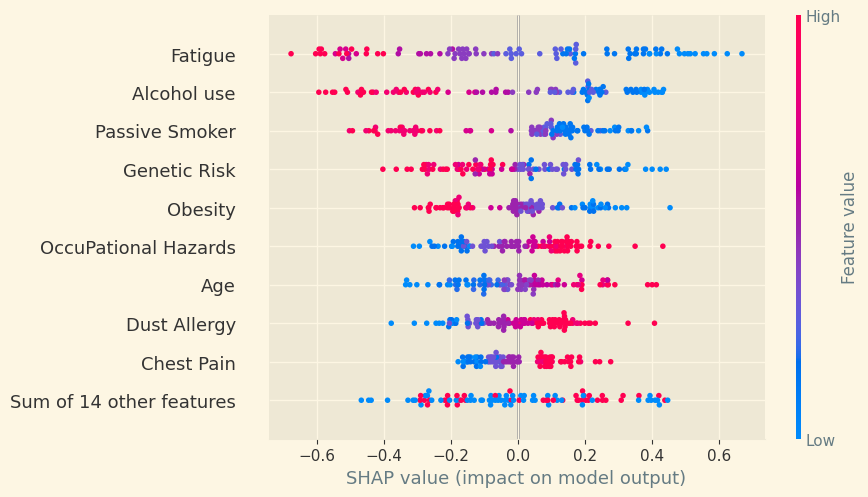

In [37]:
shap.plots.beeswarm(shap_values) # For all samples — global importance summary

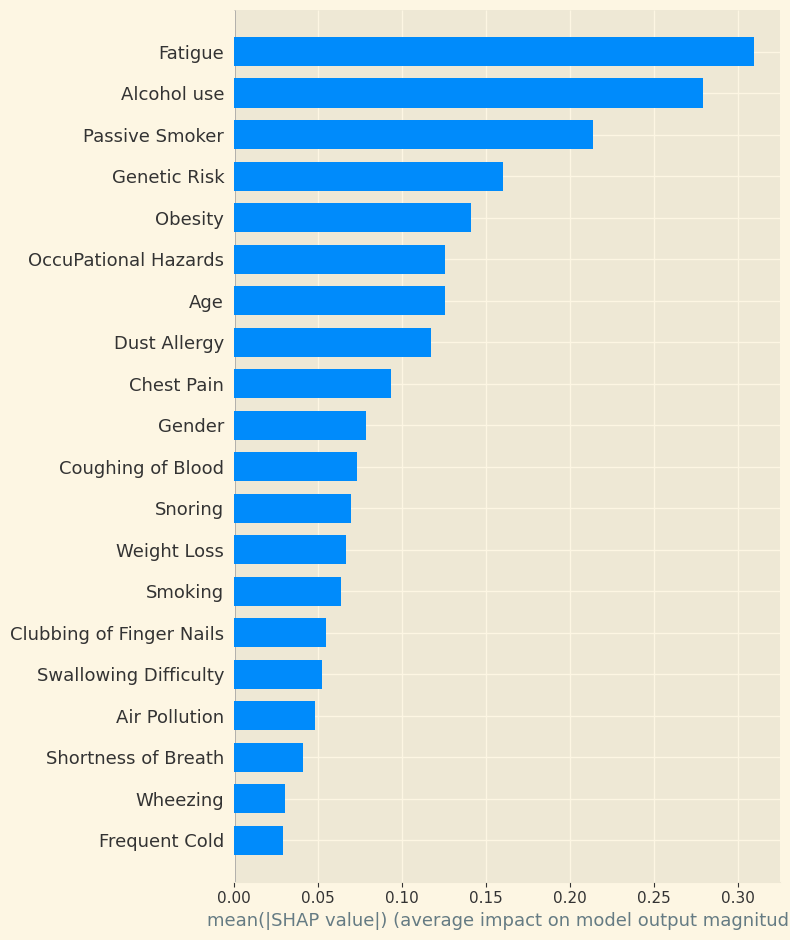

In [38]:
shap.summary_plot(shap_values,X,plot_type="bar",show=True)

In [39]:
df.columns[[3,14,11,6,9,5,4,0]]

Index(['Alcohol use', 'Fatigue', 'Passive Smoker', 'Genetic Risk', 'Obesity',
       'OccuPational Hazards', 'Dust Allergy', 'Age'],
      dtype='object')

## LIME 
**Local Interpretable Model-agnostic Explanations**

In [40]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer = LimeTabularExplainer(
    X_train.values, feature_names =  list(X_train.columns),  
    class_names = list(levels.keys()), 
    verbose=True,mode = 'classification')

In [41]:
rf.predict_proba(X_test.iloc[[1]])

array([[0., 0., 1.]])

Intercept 0.4240347707906355
Prediction_local [0.3696]
Right: 0.0


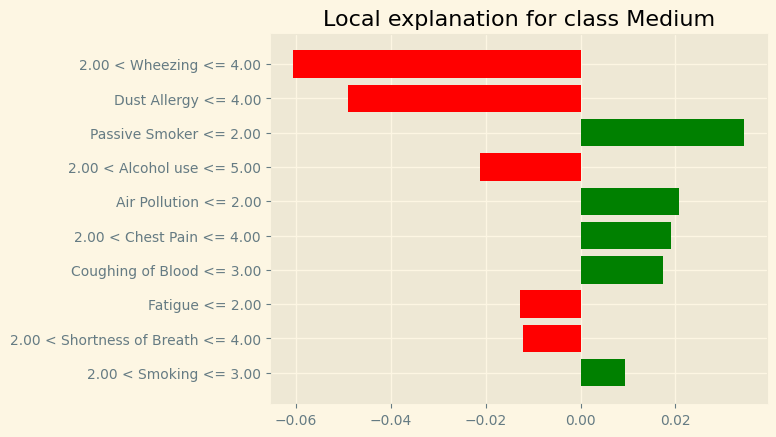

In [42]:
instance_explanation=lime_explainer.explain_instance(X100[1],rf.predict_proba)
instance_explanation.as_pyplot_figure()
instance_explanation.save_to_file('lime_explanation.html')

In [43]:
# print(instance_explanation.as_list())

In [20]:
rf.classes_

array(['High', 'Low', 'Medium'], dtype=object)

In [21]:
! pip install ipynb-py-convert

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ipynb-py-convert: filename=ipynb_py_convert-0.4.6-py3-none-any.whl size=4719 sha256=915717d3fd6802abe91c0d2633821f6d283e00c6a3f993f1658ae2b573dba79b
  Stored in directory: c:\users\sriram.a\appdata\local\pip\cache\wheels\05\92\10\684f07f9fbb11bdca1f6bcb76f13e68bd1b31db030d59520ed
Successfully built ipynb-py-convert


In [1]:
# ! ipynb-py-convert AIML_EL.ipynb AIML_EL.py

In [44]:
len(rf.estimators_)

100

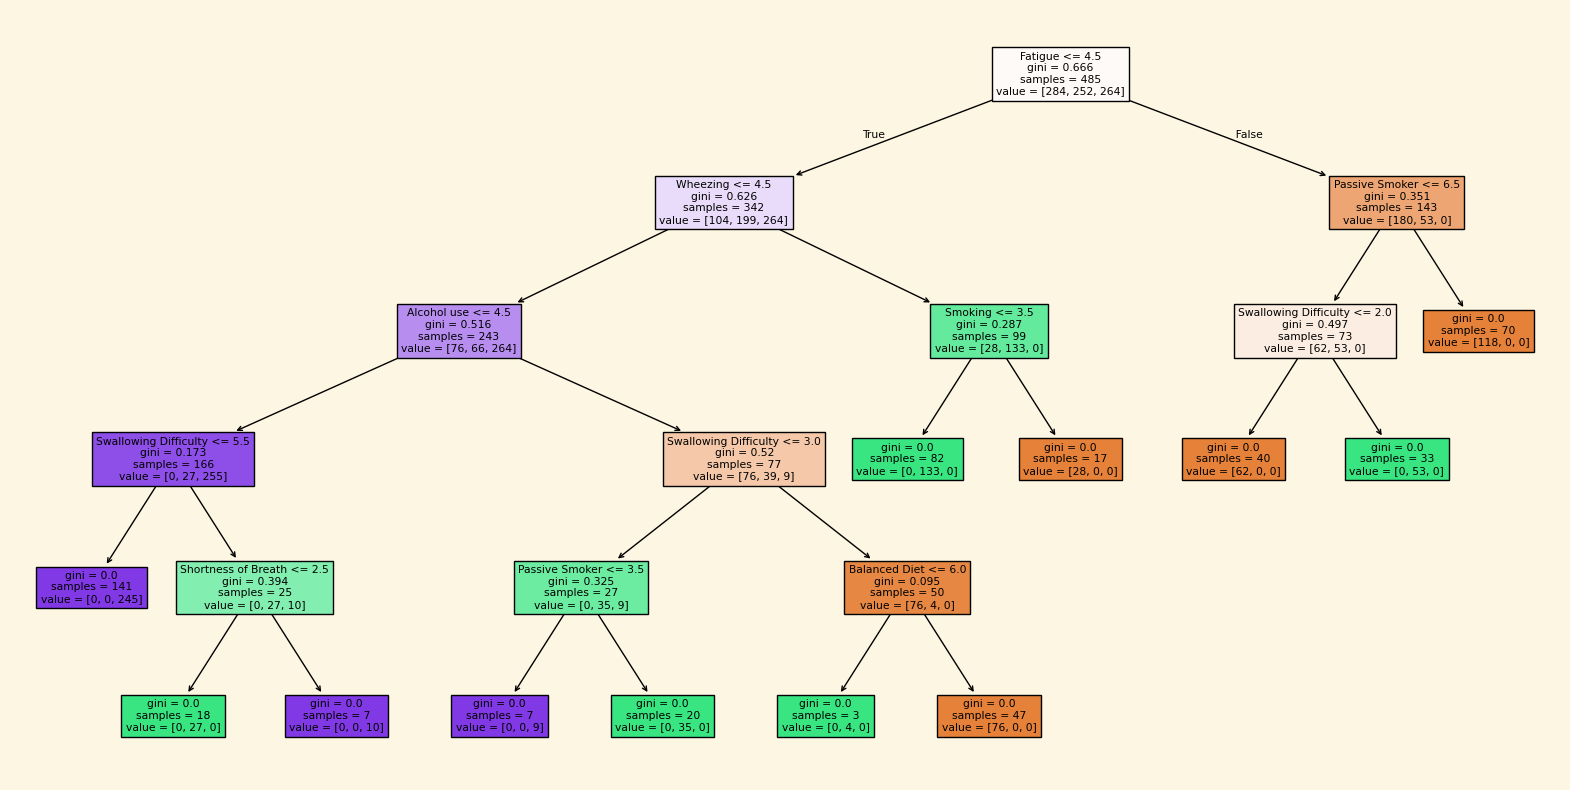

In [45]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

In [30]:
str(rf)

'RandomForestClassifier()'

In [39]:
# Saving all models
from joblib import dump
import os
def save_model(model):
    os.makedirs("ml_models",exist_ok=True)
    dump(model,os.path.join("models",str(model)+".joblib"))  
# save_model(nb)